# Lab 3: Asking a statistical question

## Problem 1

In [25]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import norm

In [26]:
# Create our data
mean = 12
sigma = 0.4
bad_data = np.array([10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7])
good_data = norm.rvs(loc=mean, scale=sigma, size=100000)
t_data = np.concatenate((good_data, bad_data), axis=None);

### A

1.) Start by exploring the data you have created

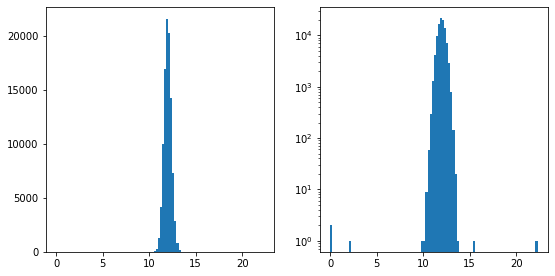

In [27]:
figure = plt.figure(figsize=[9, 4.5])
axes = figure.subplots(1, 2)

axes[0].hist(t_data, bins=100);
axes[1].set_yscale('log')
axes[1].hist(t_data, bins=100);

2.) State the statistical question in words. Be very clear and describe why you have chosen this statistical question.

Given that our expected distribution is a guassian with a mean of 12, and a sigma of 0.4, what are the statistical outlier data points for a cut off sigma of 1.5? This outlier threshold has been chosen arbitrarily. Once the statistical outliers have been discovered, discard that data. If data is not a statistical outlier, include that data.

3.) Restate your question in math. Be very clear.

We want to check the percentile of each data point and find the sigma associated with that percentile. For data points greater than 12, we want to integrate from the data point to infinity. For data points less than 12,  we want to integrate from the data point to negative infinity.

4.) Apply your statisical test and construct a truth table.

In [28]:
import pandas as pd

# Calculate boundaries of good data with sigma threshold 
threshold = 1.5

upper_boundary = threshold * sigma + mean # calculated by z-score definition
lower_boundary = -threshold * sigma + mean

# loop through data, place values outside bounds in bad_data
# data in the bounds in good_data
negative_data = []
positive_data = []
for idx in range(0, len(t_data)):
    candidate = t_data[idx]
    if(lower_boundary < candidate < upper_boundary):
        positive_data.append(candidate)
    else:
        negative_data.append(candidate)
        
# Calculate table
true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0

for idx in range(0, len(positive_data)):
    current_value = positive_data[idx]
    if current_value in good_data:
        true_positive += 1
    else:
        false_positive += 1

for idx in range(0, len(negative_data)):
    current_value = negative_data[idx]
    if current_value in bad_data:
        false_negative += 1
    else:
        true_negative += 1
    
# Display as a truth table
data = {'True': [true_positive, true_negative], 
        'False': [false_positive, false_negative]}
df = pd.DataFrame(data, index=['Positive', 'Negative'])
df.head()

,True,False
Positive,86621,0
Negative,13379,8


### B.

How does the number of omissions, where you threw out good data, depend on the statistical threshold you chose and is it a predicatble quantity?

It depends on the statistical threshold because if it is outside of the sigma threshold, it will get chopped, even though they might be true values. It is a predictable quantity because I can calculate what percentile my sigma cutoff is, so the amount of data that should be incorrectly thrown out should be:

1 - (upper threshold oper) - (the percentile cutoff of my lower chosen sigma threshold) percent of the data. 

### C. 

Are there mistakes of commission (bad data getting in)? If yes, are they avoidable and how do they depend on your statistical threshold?

This will be yes if my threshold is greater than 12.7 or less than 10.3. They are avoidable and they depend on what the value of measurement is for the chosen sigma threshold.

## Problem 2

In this example we will be looking for asteroids. If we look at star alignment, we don't get perfect alignment due to a number of factors. The distribution of these discrepancies is a 2d gaussian.

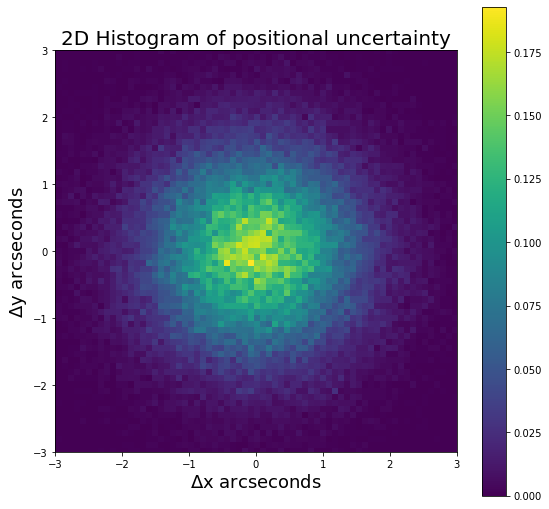

In [29]:
N = 100000
x = stats.norm.rvs( scale = 1, size = N)
y = stats.norm.rvs( scale = 1, size = N)
#r = np.sqrt(x*x + y*y)
#index = round(N -N/3.5/1e6)
# print(index, r(index))
coords = np.vstack((x, y))
coords.shape
fig = plt.figure(figsize=(9, 9))
ax = fig.subplots(1, 1)
h = ax.hist2d(coords[0,:], coords[1,:], bins=100, density=True);
ax.set_aspect('equal', 'box')
plt.xlim([-3 , 3])
plt.ylim([-3 , 3])
plt.title("2D Histogram of positional uncertainty", fontsize = 20)
plt.ylabel("$\Delta$y arcseconds", fontsize = 18)
plt.xlabel("$\Delta$x arcseconds", fontsize = 18)
plt.colorbar(h[3], ax=ax);

If I have a potential asteroid, it will have some true movement between the images. We would like a 5 sigma detection of movement. What is that distance in arcseconds?

1.) What is the question in words?

What is a 5 sigma percentile radial movement in this 2D distribution? That is, I need to calculate a distribution that is 1D so that my integration is simplified, which means I want a distribution that is radially out from the origin. In other words, R = sqrt(X^2 + Y^2) is a distribution that I can easily integrate over and it fully describes the type of motion I wish to detect. This distribution happens to be the Rayleigh distribution, since the sigma for X and Y are the same and the mean is 0.

2.) What is the question in math?

We want to integrate from infinity inwards on the Rayleigh distribution with sigma=1 until we get a sigma of 5, or a percentile of 1 - 3.5e-6.

1.7067212947438688
False


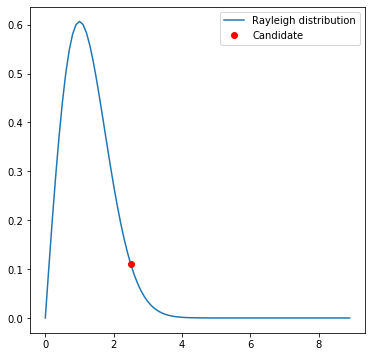

In [30]:
from scipy.stats import rayleigh
# Before we find 5 sigma detection, lets investigate how to find the sigma
# value given a simulated measurement.
candidate = [1.5, -2] # [delta_x, delta_y]
radius = np.sqrt(candidate[0]**2 + candidate[1]**2)

# Lets make a plot to see whats happening
x = np.arange(0, 9, 0.1)
distribution = rayleigh.pdf(x)
r = rayleigh.pdf(radius)

figure = plt.figure(figsize=[6,6])
axis = figure.subplots(1, 1)
axis.plot(x, distribution, label='Rayleigh distribution');
axis.plot(radius, r, 'ro', label='Candidate');
axis.legend()

# Lets integrate from radius to infinity now to get the percentile
percentile = rayleigh.cdf(radius)

# And now find the sigma and see if it is a detection
candidate_sigma = norm.ppf(percentile)
detection = candidate_sigma >= 5

print(candidate_sigma)
print(detection)

In [31]:
# Now that we know how to find the sigma, lets work backwards
detection_sigma = 1/3.5e6

detection_boundary = rayleigh.ppf(1 - detection_sigma)
print("The radius of Delta arcseconds from (0,0) for detection is " 
     + str(detection_boundary))

The radius of Delta arcseconds from (0,0) for detection is 5.489676406965609


## Problem 3

Assume a moon sized patch on the sky we normally have a cosmic ray rate of 1 cosmic ray per minute (arrivals are random in time). If we can observe where the moon is for 8 hours per night (not too close to the horizon) and we observe for 15 days and see 6800 cosmic rays, what is the signficance of our moon shadow detection?

1.) What is the question in words?

What is the significance of having 6800 events occur over 120 hours when the average is 1 event per minute?

2.) Translate the question to math, describing both the expected background pdf() and the integral you need to do.

This will be a poisson distribution with an average of 1 event, and I will be integrating this pdf multiplied by 120 * 60 (7200) trials from 0 to 6800 to determine the significance.

3.) Convert to sigma.

(4000, 11000)

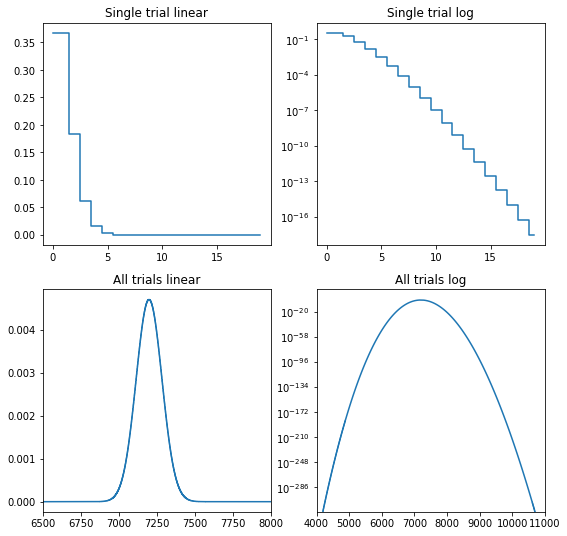

In [32]:
from scipy.stats import poisson
# The tweakable parameters
trials = 15*8*60
single_avg = 1
candidate = 6800
single_x = np.arange(0, 20, 1)
trials_x = np.arange(0, 15000, 1)

# Calculated parameters
trials_avg = single_avg * trials
single_d = poisson.pmf(single_x, single_avg)
trials_d = poisson.pmf(trials_x, trials_avg)

# Graph the parameters to see whats happening
figure = plt.figure(figsize=[9,9])
axes = figure.subplots(2, 2)
single_linear = axes[0, 0]
single_log = axes[0, 1]
trials_linear = axes[1, 0]
trials_log = axes[1, 1]

single_linear.step(single_x, single_d, where='mid')
single_linear.set_title('Single trial linear')
single_log.step(single_x, single_d, where='mid')
single_log.set_title('Single trial log')
single_log.set_yscale('log')

trials_linear.step(trials_x, trials_d, where='mid')
trials_linear.set_title('All trials linear')
trials_linear.set_xlim([6500, 8000])
trials_log.step(trials_x, trials_d, where='mid')
trials_log.set_title('All trials log')
trials_log.set_yscale('log')
trials_log.set_xlim([4000, 11000])

In [33]:
# since our candidate is to the left of the mean, we want to integrate from
# 0 to candidate. This makes sense because we want to see how significant
# the lack of events is.

adjusted_candidate = candidate / trials
percentile = poisson.cdf(adjusted_candidate, 1)
sigma = norm.ppf(1 - percentile)
print('The percentile of this number of events is: ' + str(percentile))
print('The sigma of this number of events is: ' + str(sigma))

The percentile of this number of events is: 0.36787944117144245
The sigma of this number of events is: 0.33747496376420216
